In [1]:
# http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *

from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from fastai.utils.collect_env import *

from torch.utils.data import DataLoader, Dataset
from torch import nn

from skimage.util import montage
import pandas as pd

from torch import optim
import re

from functional import seq

from os.path import isfile
from utils import *

In [3]:
show_install()



```text
=== Software === 
python        : 3.7.0
fastai        : 1.0.40.dev0
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-44-generic-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 Bionic Beaver
conda env     : fastai_updated
python        : /home/dollofcuty/anaconda3/envs/fastai_updated/bin/python
sys.path      : 
/media/dollofcuty/E604249504246B2F/Users/chrun/Documents/Projects/Machine Learning/unstructured data/whale-identification
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python37.zip
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/lib-dynload
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages
/home/dollofcuty/fastai
/home/do

In [4]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

Posing the problem as a classification task is probably not ideal. We are asking our NN to learn to recognize a whale out of 5004 possible candidates based on what it has learned about the whales. That is a tall order.

Instead, here we will try to pose the problem as a verification task. When presented with two images of whale flukes, we will ask the network - are the images of the same whale or of different whales? In particular, we will try to teach our network to learn features that can be useful in determining the similarity between whale images (hence the name of this approach - feature learning).

This seems like a much easier task, at least in theory. Either way, no need to start with a relatively big CNN like resnet50. Let's see what mileage we can get out of resnet18.

In [5]:
# new architecture calls for a new validation set, this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].sample(frac=0.2, random_state=21).Image)

In [6]:
len(df), len(val_fns) #only 10%!

(25361, 514)

In [7]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'siamese-cropped-dropout'

In [8]:
average = [257., 619.]
SZ = np.array(average)//1.5
SZ

array([171., 412.])

In [9]:
BS = 64
NUM_WORKERS = 8
SEED=0

In [10]:
# data_block api creates categories based on classes it sees in the train set and
# our val set contains whales whose ids do not appear in the train set
classes = df.Id.unique()

In [11]:
xtra = [jitter(magnitude=(-0.001,0.001), is_random=True, p=0.75)]

In [12]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-bbox', cols=['Image']) #[df.Id != 'new_whale']
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.4, max_rotate=5, max_zoom=1., xtra_tfms=xtra), 
                   size=SZ, resize_method=ResizeMethod.SQUISH)
)

In [13]:
#todo: try multiple images at once (lap solution maybe)

In [14]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds, tfms):
        self.ds = ds
        self.tfms = tfms
        self.x = ds.x
        self.y = ds.y
        self.whale_ids = ds.y.items
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: return self.sample_different((idx-1) // 2)
    def sample_same(self, idx):
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    
    def sample_different(self, idx):
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [15]:
train_dl = DataLoader(
    TwoImDataset(data.train, data.train.tfms),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid, data.valid.tfms),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

data_bunch = ImageDataBunch(train_dl, valid_dl)

In [16]:
len(data_bunch.train_ds), len(data_bunch.valid_ds)

(30366, 1028)

In [17]:
import types
def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        return x[0],y

In [18]:
data_bunch.one_batch = types.MethodType(one_batch,data_bunch)

In [19]:
data_bunch.one_batch()[0].shape

torch.Size([64, 3, 160, 416])

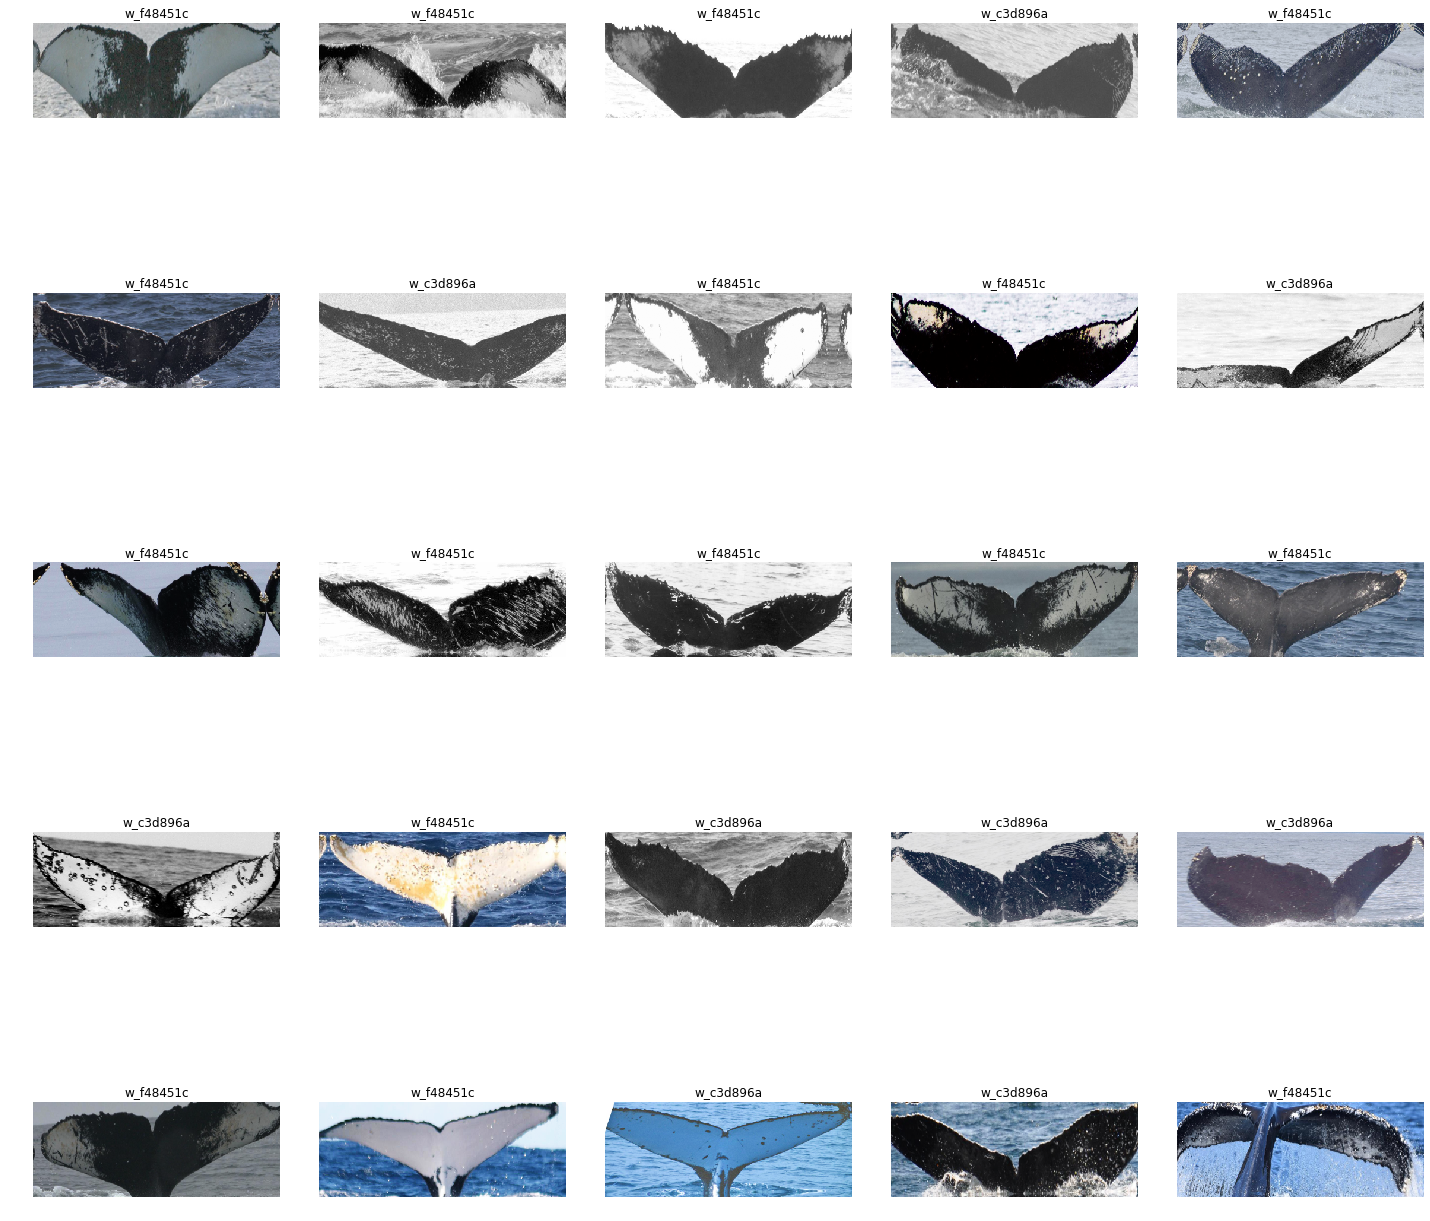

In [20]:
data_bunch.show_batch(5, DatasetType.Train)

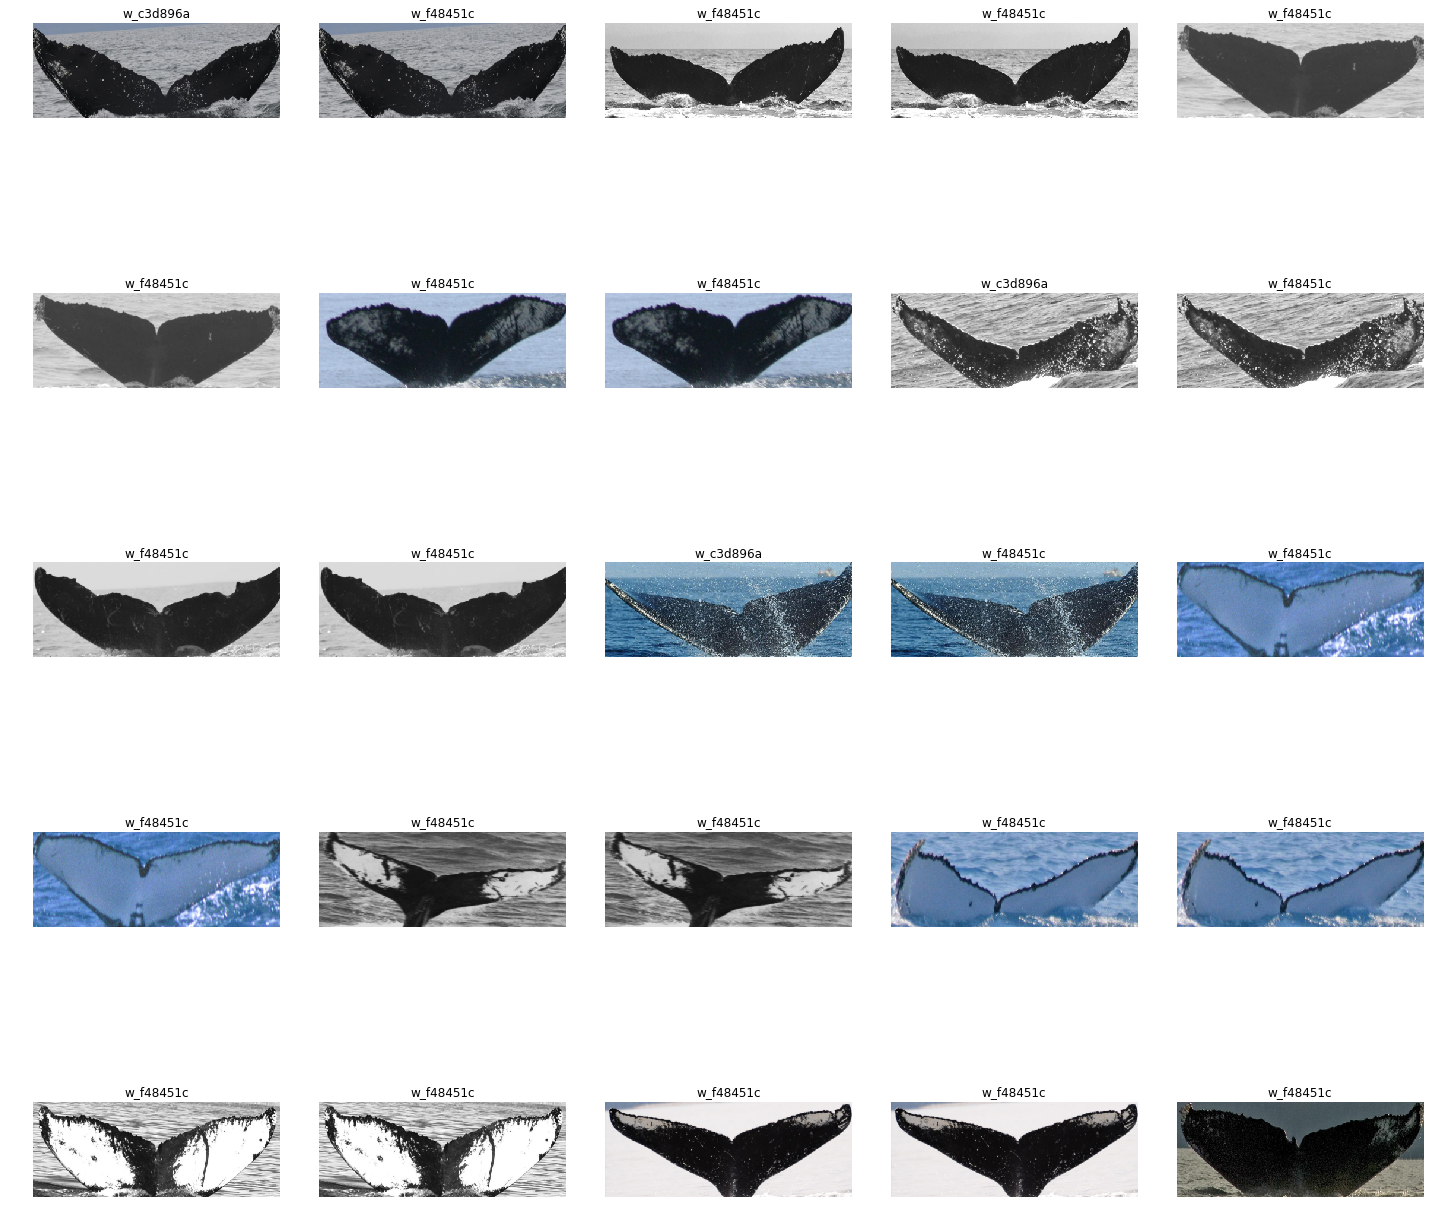

In [21]:
data_bunch.show_batch(5, DatasetType.Valid)

In [22]:
#paths = np.append(np.append(data.train.x.items, data.valid.x.items), data.test.x.items)

In [23]:
#means = torch.zeros(3)
#stds = torch.zeros(3) 
#
#count =  len(paths)
#count

In [24]:
#for i, fname in enumerate(paths):    
#    img = Image(pil2tensor(PIL.Image.open(fname).convert('RGB'), np.float32).div_(255)).data
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2])])
#    if i % 10000 == 0: print(i)
#
#mean = means/count
#std = stds/count
#mean, std

In [25]:
#stats = ([0.4670, 0.4965, 0.5322], [0.2385, 0.2414, 0.2466])
stats = ([0.4556, 0.4866, 0.5243], [0.2378, 0.2417, 0.2478])

In [26]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [27]:
data_bunch.add_tfm(normalize_batch)

In [28]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=self.learn.recorder.metrics[-1:][0][i]
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
        return values.get(self.monitor)

In [29]:
class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}')

In [30]:
from functional import seq

class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet34):
        super().__init__()
        self.cnn = create_body(arch)
        #self.cnn[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        actn = nn.ReLU(inplace=True)
        
        mid = 32
        self.conv1 =  nn.Sequential(*[nn.Conv2d(1,mid, kernel_size = (  1, 4), padding = 0, stride=1), actn])
        self.conv2 =  nn.Sequential(*[nn.Conv2d(1,  1, kernel_size = (mid, 1), padding = 0, stride=1), Flatten()])
        
        self.bdl  =  nn.Sequential(*[nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(in_features=512, out_features=64, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(in_features=64, out_features=1, bias=True)])

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
        #print(x1.shape, x2.shape)
        feat = self.calculate_features(x1, x2)
        #print(feat.shape)
        feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
        con1 = self.conv1(feat)
        #print(con1.shape)
        con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
        con2 = self.conv2(con1)
        #print(con2.shape)
        con2 = con2.view(-1, num_features_model(self.cnn))
        out = self.bdl(con2)
        #out = self.fc(con2)
        #print(out)
        return out

    def calculate_features(self, x1, x2):
        mu = x1 * x2
        ad = x1 + x2
        mi = torch.abs(x1-x2)
        sq = mi**2
        x = torch.cat([mu, ad, mi, sq], dim=1)
        return x

    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]

In [31]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [32]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [33]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [35]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


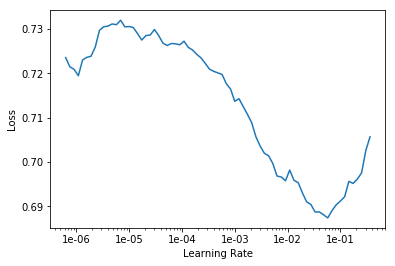

In [35]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.345145,0.417624,0.857004
2,0.305454,0.358152,0.875486
3,0.238434,0.182928,0.945525
4,0.193062,0.157085,0.942607


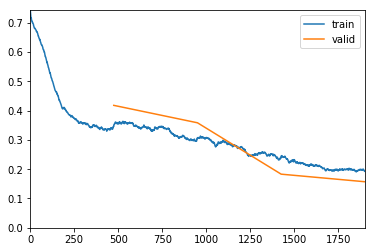

In [36]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,
1,0.390959,0.366539,0.811868
2,0.345157,0.290291,0.854475
3,0.244948,0.212578,0.897860
4,0.215003,0.181265,0.912451


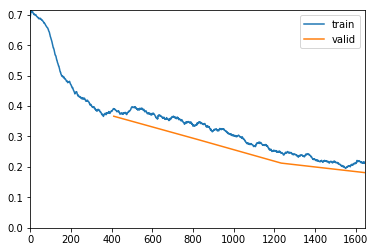

In [38]:
learn.fit_one_cycle(4, 1e-2)

In [37]:
learn.save(f'{name}-stage-1')

In [38]:
learn.unfreeze()

In [39]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-stage-2'))

In [40]:
max_lr = 4e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([4.444444e-05, 1.333333e-04, 4.000000e-04])

epoch,train_loss,valid_loss,
1,0.195310,0.152408,0.948444
2,0.196585,0.152487,0.951362
3,0.188294,0.188795,0.937743
4,0.202563,0.175345,0.939689
5,0.191924,0.136519,0.953307
6,0.185892,0.206417,0.933852
7,0.176496,0.184055,0.940661
8,0.157258,0.132341,0.961089
9,0.167933,0.135282,0.951362
10,0.155688,0.164084,0.951362


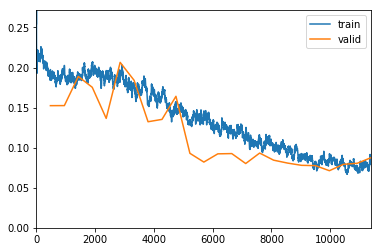

In [41]:
learn.fit_one_cycle(24, lrs) #4e-4, 24e, slice(max_lr/9,max_lr), div_factor=25

epoch,train_loss,valid_loss,
1,0.197411,0.194102,0.904280
2,0.186112,0.182266,0.917315
3,0.195833,0.191585,0.925681
4,0.197018,0.261759,0.864981
5,0.184649,0.226734,0.893969
6,0.176805,0.169893,0.919066
7,0.186169,0.187105,0.919455
8,0.163679,0.143364,0.941440
9,0.154994,0.226481,0.894942
10,0.143214,0.146704,0.934825


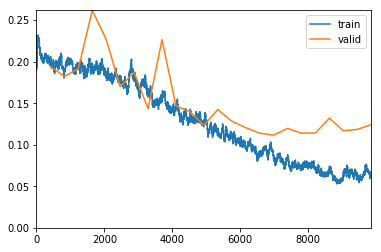

In [40]:
learn.fit_one_cycle(24, lrs) #4e-4, 24e, slice(max_lr/9,max_lr), div_factor=25

The model is not doing that well - out of presented pairs it gets roughly 10% of examples wrong. I also did a cursory error analysis (not shown here for the sake of brevity) and the model is not doing that great at all.

How can this be? Maybe the nearly absolute positional invariance through the use of global max pooling is not working that well. Maybe there is a bug somewhere? Maybe the model has not been trained for long enough or lacks capacity?

If I do continue to work on this I will definitely take a closer look at each of the angles I list above. For the time being, let's try to predict on the validation set and finish off with making a submission.

The predicting part is where the code gets really messy. That is good enough for now though.

## Size 257x619

In [34]:
SZ_BIG = np.array(average) * 1.2
SZ_BIG

array([308.4, 742.8])

In [35]:
#SZ_BIG = average
BS = 16
NUM_WORKERS = 8

In [36]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-bbox', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.4, max_rotate=5, max_zoom=1., xtra_tfms=xtra), 
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
)

In [37]:
#data.train.x.convert_mode = 'L'
#data.valid.x.convert_mode = 'L'
#data.test.x.convert_mode = 'L'

In [38]:
train_dl = DataLoader(
    TwoImDataset(data.train, data.train.tfms),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid, data.valid.tfms),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [39]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

data_bunch.add_tfm(normalize_batch)

In [40]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [41]:
#learn.data.train_ds.ds.x.convert_mode = 'L'
#learn.data.valid_ds.ds.x.convert_mode = 'L'

In [42]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [43]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [52]:
learn.load(f'{name}-stage-2');

In [53]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


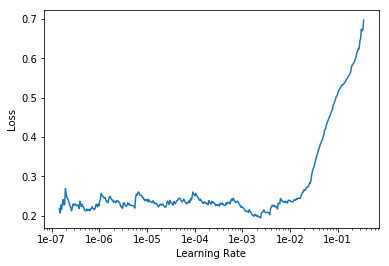

In [54]:
learn.lr_find(num_it=500)
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.173062,0.107688,0.962062
2,0.189662,0.196390,0.939689
3,0.158547,0.103111,0.967899
4,0.141234,0.109381,0.962062


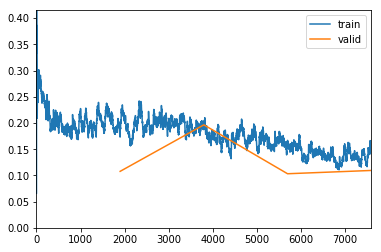

In [56]:
learn.fit_one_cycle(4, 4e-3)

epoch,train_loss,valid_loss,
1,0.217510,0.188354,0.909922
2,0.179325,0.163783,0.941245
3,0.165634,0.129730,0.944747
4,0.153234,0.120252,0.951946


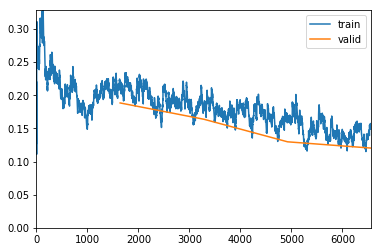

In [54]:
get_translearn.fit_one_cycle(4, 4e-3)

In [57]:
learn.save(f'{name}-big-stage-1')

In [47]:
learn.load(f'{name}-big-stage-1');

Learner(data=ImageDataBunch;

Train: <__main__.TwoImDataset object at 0x7f1f51c49278>;

Valid: <__main__.TwoImDataset object at 0x7f1f51d3ac18>;

Test: None, model=SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, 

In [48]:
learn.unfreeze()

In [49]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-big-stage-2'))

In [51]:
max_lr = 1e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([1.111111e-05, 3.333333e-05, 1.000000e-04])

epoch,train_loss,valid_loss,
1,0.150404,0.130266,0.959144
2,0.134196,0.160878,0.956226
3,0.163203,0.120148,0.967899
4,0.149586,0.105675,0.967899
5,0.164890,0.128579,0.962062
6,0.148369,0.141024,0.963035
7,0.126392,0.148975,0.966926
8,0.147309,0.109806,0.966926
9,0.161406,0.192477,0.964008
10,0.131275,0.100634,0.968872


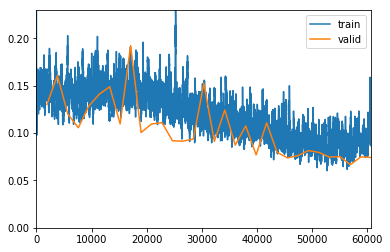

In [52]:
learn.fit_one_cycle(32, lrs, div_factor=40) #2e-4, slice(max_lr/9,max_lr), div_factor=50

epoch,train_loss,valid_loss,
1,0.152083,0.116193,0.961284
2,0.134081,0.128480,0.948638
3,0.149627,0.120541,0.950973
4,0.165934,0.132706,0.946303
5,0.164533,0.150335,0.931907
6,0.161876,0.149382,0.934630
7,0.141695,0.143711,0.937743
8,0.188046,0.149341,0.944553
9,0.192878,0.170522,0.918677
10,0.169486,0.146812,0.937354


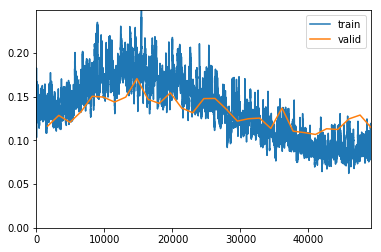

In [59]:
learn.fit_one_cycle(30, lrs, div_factor=50) #3e-4, slice(max_lr/9,max_lr), div_factor=50

In [41]:
learn.callback_fns.pop()

functools.partial(<class '__main__.SaveModel'>, every='improvement', name='res34-siamese-differenthead-448-stage-2')

## validate 

In [45]:
#name='res34-siamese-differenthead'

In [44]:
learn.load(f'{name}-big-stage-2_31');

In [45]:
learn.model.eval();

In [46]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:500])
len(new_whale_fns)

500

In [47]:
SZ_BIG = np.array(average) * 1.2
SZ_BIG

array([308.4, 742.8])

In [48]:
BS = 16
NUM_WORKERS = 8

In [49]:
data = (
    ImageItemList
        .from_df(df, f'data/train-bbox', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns)) #.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.4, max_rotate=5, max_zoom=1., xtra_tfms=xtra), 
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [50]:
#x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
#feat = self.calculate_features(x1, x2)
#feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
#con1 = self.conv1(feat)
#con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
#con2 = self.conv2(con1)
#con2 = con2.view(-1, num_features_model(self.cnn))
#out = self.fc(con2)

In [ ]:
#TODO: try getting TTA to work (body only model that loads state of the best epoch)

In [52]:
#targs, feats = learn.TTA(ds_type=DatasetType.Valid, scale=0.)

In [53]:
%%time
targs = []
feats = []
for ims, ts in data.valid_dl:
    #print(ims.shape)
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

In [54]:
feats = torch.cat(feats)

In [56]:
targs = torch.cat(targs)

In [59]:
feats.shape, targs.shape

(torch.Size([1028]), torch.Size([1028, 1]))

In [65]:
feats[0]

tensor(1)

In [61]:
%%time
sims = []
for feat in feats:
    x1 = feats
    x2 = feat.unsqueeze(0).repeat(1014 ,1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity = learn.model.bdl(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

RuntimeError: shape '[-1, 1, 512, 4]' is invalid for input of size 4227136

In [83]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]

In [84]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 226 ms, sys: 215 µs, total: 226 ms
Wall time: 225 ms


In [103]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.4572320841551611

In [61]:
#best mapk so far: 0.6812138188608777

0.6812138188608777

In [86]:
%%time
thresh_dict = {}

for thresh in np.linspace(0.9, 1, 11):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    thresh_dict[thresh] = np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6)
    print(thresh, np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6))

0.9 0.405671
0.91 0.406164
0.92 0.406328
0.93 0.406821
0.9400000000000001 0.406821
0.95 0.406821
0.96 0.407561
0.97 0.411095
0.98 0.417801
0.99 0.428895
1.0 0.514053
CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.12 s


In [106]:
thresh = max(thresh_dict, key=thresh_dict.get)
thresh

0.992

In [107]:
#best thresh: 0.999

In [108]:
%%time

top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 230 ms


In [ ]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

In [69]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.7276330532212886

There are many reasons why the best threshold here might not carry over to what would make sense on the test set. It is some indication though of how our model is doing and a useful data point.

## Predict

In [109]:
len(data.test_ds)

7960

In [110]:
data = (
    ImageItemList
        .from_df(df, f'data/train-bbox', cols=['Image'])
        .no_split()
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-bbox'))
        .transform(get_transforms(max_lighting=0.4, max_rotate=5, max_zoom=1., xtra_tfms=xtra), 
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [111]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())

CPU times: user 32.9 s, sys: 16.7 s, total: 49.6 s
Wall time: 50.6 s


In [112]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
    train_class_idxs.append(t)

CPU times: user 1min 59s, sys: 54.9 s, total: 2min 54s
Wall time: 3min 9s


In [113]:
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [114]:
test_feats = torch.cat(test_feats)

In [115]:
train_feats.shape, test_feats.shape

(torch.Size([25360, 512]), torch.Size([7960, 512]))

In [116]:
%%time
sims = []
for feat in test_feats:
    x1 = train_feats
    x2 = feat.unsqueeze(0).repeat(25360, 1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity =  learn.model.bdl(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 28min 55s, sys: 19min 55s, total: 48min 50s
Wall time: 48min 53s


In [117]:
#todo: verify thresh

In [118]:
thresh

0.992

In [136]:
thresh = 0.996

In [137]:
%%time

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending = True)
    probs = sim[idxs]
    top_5 = []
    for  i , p in zip(idxs , probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5:
            top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        #if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        #print(predicted_class)
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5:
            top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 23.2 s, sys: 787 ms, total: 24 s
Wall time: 24 s


In [138]:
top_5_classes = []
for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [139]:
top_5_classes[:5]

['w_dec7ffd new_whale w_ae53e45 w_d7aef56 w_17b0d3a',
 'new_whale w_4132bb8 w_636aa5b w_ee57fc5 w_46796cc',
 'new_whale w_34d7623 w_31b5dd8 w_d066c0a w_94c3bf0',
 'new_whale w_a335fc2 w_59052ad w_c99807e w_2f1488c',
 'w_1647882 w_9e18daa w_69c06ad new_whale w_ecf39ca']

In [140]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [141]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,00028a005.jpg,w_dec7ffd new_whale w_ae53e45 w_d7aef56 w_17b0d3a
1,000dcf7d8.jpg,new_whale w_4132bb8 w_636aa5b w_ee57fc5 w_46796cc
2,000e7c7df.jpg,new_whale w_34d7623 w_31b5dd8 w_d066c0a w_94c3bf0
3,0019c34f4.jpg,new_whale w_a335fc2 w_59052ad w_c99807e w_2f1488c
4,001a4d292.jpg,w_1647882 w_9e18daa w_69c06ad new_whale w_ecf39ca


In [142]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(
    lambda x: x[0] == 'new_whale').mean()

0.5248743718592965

In [143]:
pd.read_csv(f'data/train.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3810575292772367

In [144]:
name

'siamese-cropped-dropout'

In [ ]:
#try only 20% of val set and training with hard examples 

#thresh 0.996
#0.609 local lb

#thresh 0.992
#0.607 local lb

In [ ]:
#fastai head after conv 0.1, 0.2 dropout epoch: 24
#thresh 0.99
#0.687 local lb

#thresh 0.995
#0.699 local lb

#thresh 0.996
#0.695 local lb

#fastai head after conv 0.1, 0.2 dropout epoch: 28
#thresh 0.995
#0.685 local lb

#thresh 0.994
#0.697 local lb